##Import libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Dataset Handling

In [2]:
#download the dataset
train_data = datasets.CIFAR100(root = '/data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.CIFAR100(root = '/data', train = False, transform = transforms.ToTensor())

100%|██████████| 169001437/169001437 [00:03<00:00, 42822108.85it/s]


Extracting /data/cifar-100-python.tar.gz to /data


In [3]:
#Preparing the train loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = False)

In [4]:
#Visualizing the dataset
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

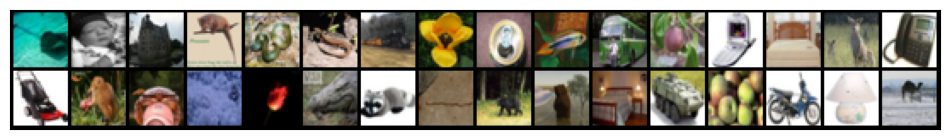

In [5]:
show_batch(train_loader)

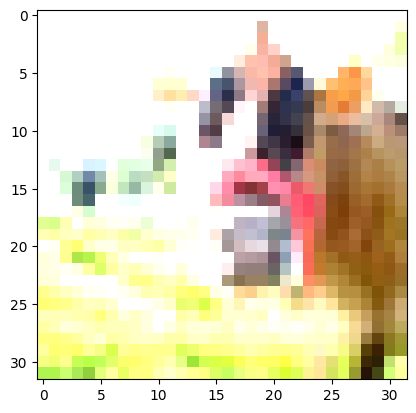

In [6]:
#Visualizing a single data point
dataiter = iter(train_data)
# Get a batch of training images and labels
images, labels = next(dataiter)

# Function to unnormalize and plot images
def imshow(img):
    img = img /0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

##Depthwise convlution without skip connections

In [7]:
class Depthwise(nn.Module):
    def __init__(self, input_channels , out_channels):
        super(Depthwise , self).__init__()
        self.depthwise = nn.Conv2d(input_channels, input_channels, kernel_size=3) #depth wise convolution which is aplied over single channel
        self.pointwise = nn.Conv2d(input_channels, out_channels, kernel_size=1) #pointwise convolution
        self.Relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(input_channels) #batch-normaliztion layers
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x): #forward pass
        x = self.depthwise(x)
        x = self.batch_norm1(x)
        x = self.Relu(x)
        x = self.pointwise(x)
        x = self.batch_norm2(x)
        x = self.Relu(x)

        return x

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 4 block architecture networks
        self.conv1 = nn.Sequential(Depthwise(3 , 32), nn.ReLU(), nn.MaxPool2d(kernel_size=1))
        #one residual block with maxpooling and relu activation
        self.conv2 = nn.Sequential(Depthwise(32 , 64), nn.ReLU(), nn.MaxPool2d(kernel_size=1))
        self.conv3 = nn.Sequential(Depthwise(64 , 128), nn.ReLU(), nn.MaxPool2d(kernel_size=1) )
        self.conv4 = nn.Sequential(Depthwise(128 , 256),nn.ReLU(), nn.MaxPool2d(kernel_size=2) )
        self.out = nn.Linear(in_features= 36864, out_features= 100) # nn.Linear creates a single layer

    #forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [9]:
#Define model
model = CNN().to(device)

#Loss fuction
criterion = nn.CrossEntropyLoss()

#Optimizer with lr 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [50]:
#training loop
train_loss = [] # empty list to contain all the losses per epoch
def train(num_epochs, model, train_loader, criterion, optimizer):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            output = model(images)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss}")

    return train_loss

In [51]:
train(num_epochs= 10, model = model , train_loader = train_loader , criterion = criterion , optimizer = optimizer ) #training the model
# print(train_Loss)

Epoch [1/10], Train Loss: 0.0030120317293943163
Epoch [2/10], Train Loss: 0.005042908723058553
Epoch [3/10], Train Loss: 0.004757384033804528
Epoch [4/10], Train Loss: 0.00531514622036569
Epoch [5/10], Train Loss: 0.002617773586553752
Epoch [6/10], Train Loss: 0.005904078513646192
Epoch [7/10], Train Loss: 0.0033219988371553867
Epoch [8/10], Train Loss: 0.004447909535325256
Epoch [9/10], Train Loss: 0.0034269659334304112
Epoch [10/10], Train Loss: 0.004218123211234338


[0.0030120317293943163,
 0.005042908723058553,
 0.004757384033804528,
 0.00531514622036569,
 0.002617773586553752,
 0.005904078513646192,
 0.0033219988371553867,
 0.004447909535325256,
 0.0034269659334304112,
 0.004218123211234338]

In [31]:
# Code for recall-precision
def eval_(model):
    acc = []
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    classes = test_loader.dataset.classes

    test_loss, correct = 0, 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)
            prediction = model(X)
            test_loss += criterion(prediction, y).item()
            pred_labels = prediction.argmax(1)
            correct += (pred_labels == y).type(torch.float).sum().item()
            all_preds.extend(pred_labels.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f'Accuracy : {correct}')
    acc.append(correct)

    return all_targets, all_preds, classes

all_targets, all_preds, classes = eval_(model)


Accuracy : 0.3431


In [28]:
precision_recall_fscore_support(all_targets,all_preds, average='macro')

(0.348497418101161, 0.3349, 0.3342013262629011, None)

In [32]:
# Test loop
test_Loss = []
acc1 = []
def test(model, test_loader, criterion):


    model.eval()
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            prediction = model(X)
            #collect all the loss
            test_loss += criterion(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    avg_test_loss = test_loss / num_batches

    accuracy = correct / size
    print(f"Test Loss: {avg_test_loss}, Accuracy: {accuracy}")
    test_Loss.append(avg_test_loss)
    acc1.append(accuracy)
    return test_Loss

In [36]:
epochs = 10

for epoch in range(epochs):
    train_loss = train(epoch + 1, model, train_loader, criterion, optimizer)
    test(model, test_loader, criterion)

Epoch [1/1], Train Loss: 0.00816361790101501
Test Loss: 8.699357664242338, Accuracy: 0.3358
Epoch [1/2], Train Loss: 0.008354376207411399
Epoch [2/2], Train Loss: 0.006075402797235233
Test Loss: 6.90941376274767, Accuracy: 0.3287
Epoch [1/3], Train Loss: 0.009518490199705427
Epoch [2/3], Train Loss: 0.007561901036794793
Epoch [3/3], Train Loss: 0.0076773469304295145
Test Loss: 8.322337404988444, Accuracy: 0.3346
Epoch [1/4], Train Loss: 0.0067620748694372625
Epoch [2/4], Train Loss: 0.008052192747078505
Epoch [3/4], Train Loss: 0.006090633189985737
Epoch [4/4], Train Loss: 0.00672681537381716
Test Loss: 7.964437467221635, Accuracy: 0.338
Epoch [1/5], Train Loss: 0.008024647595012568
Epoch [2/5], Train Loss: 0.006827035100568174
Epoch [3/5], Train Loss: 0.006829619759398575
Epoch [4/5], Train Loss: 0.008475616490217925
Epoch [5/5], Train Loss: 0.006443675475069617
Test Loss: 8.604178376852895, Accuracy: 0.3332
Epoch [1/6], Train Loss: 0.007074876742311034
Epoch [2/6], Train Loss: 0.0076

In [37]:
acc1

[0.3365,
 0.3327,
 0.3358,
 0.3287,
 0.3346,
 0.338,
 0.3332,
 0.3297,
 0.3417,
 0.3257,
 0.3296,
 0.3506]

In [45]:
test_Loss

[8.588303762502944,
 8.339731039711461,
 8.699357664242338,
 6.90941376274767,
 8.322337404988444,
 7.964437467221635,
 8.604178376852895,
 7.616075118890586,
 6.625585012923414,
 8.619887935467803,
 7.305325209523161,
 7.660550468645918,
 4.607628965530152,
 4.607628965530152,
 4.607628965530152,
 4.607628965530152,
 4.607628965530152,
 4.607628965530152,
 4.607628965530152,
 4.607628965530152,
 4.607628965530152,
 4.607628965530152]

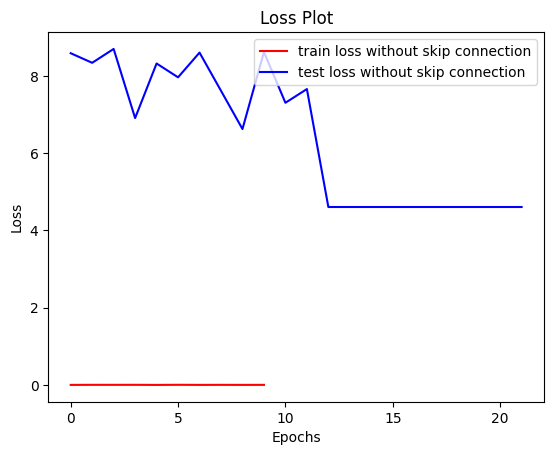

In [52]:
#Plot to plot the train loss and test loss
plt.plot(train_loss, color='r', label='train loss without skip connection')
plt.plot(test_Loss, color='b', label='test loss without skip connection')


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")

plt.legend()
plt.show()

##Depthwise convolution with skip network

In [39]:
class depth_withskip(nn.Module):
    def __init__(self, input_channels , out_channels):
        super(depth_withskip , self).__init__()
        self.depthwise = nn.Conv2d(input_channels, out_channels, kernel_size=3, padding =1)
        self.pointwise = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.depthwise1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding = 1)
        self.pointwise1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.residual1 = nn.Conv2d(input_channels, out_channels, kernel_size=1)
        self.residual2 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.Relu = nn.ReLU()
        #self.batch_norm1 = nn.BatchNorm2d(32)
        #self.batch_norm2 = nn.BatchNorm2d(64)



    def forward(self, x):
        skip1 = x.clone() # saving the input1
        x = self.depthwise(x)
        #x = self.batch_norm1(x)
        x = self.Relu(x)
        x = self.pointwise(x)
        #x = self.batch_norm2(x)
        x = self.Relu(x)

        if skip1.shape != x.shape: #did this step to check the shape and add the input1 to output x
            skip1 = self.residual1(skip1)

        x = torch.add(x, skip1)
        skip2 = x #another skip step

        x = self.depthwise1(x)
        x = self.Relu(x)
        x = self.pointwise1(x)
        x = self.Relu(x)
        if (skip2.shape != x.shape):#to check the shape
            skip2 = self.residual2(skip2)
        x = torch.add(skip2,x) #added both the skip connection
        return x

In [40]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        #4 blocks of the network
        self.conv1 = nn.Sequential(depth_withskip(3 , 32), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv2 = nn.Sequential(depth_withskip(32 , 64), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv3 = nn.Sequential(depth_withskip(64 , 128), nn.ReLU(), nn.MaxPool2d(kernel_size=2) )
        self.conv4 = nn.Sequential(depth_withskip(128 , 256),nn.ReLU(), nn.MaxPool2d(kernel_size=2) )

        self.out = nn.Linear(in_features=1024, out_features= 100) # nn.Linear creates a single layer

    #forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

# loading the model
model1 = CNN1().cuda()

#Loss fuction
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Training loop
train_Loss1 = []


def train(num_epochs, model, train_loader, criterion, optimizer):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            output = model(images)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss}")

    return train_loss


train(num_epochs= 10, model = model1 , train_loader = train_loader, criterion = criterion,optimizer= optimizer) #training the model
print(train_Loss1)

Epoch [1/10], Train Loss: 4.607647159049241
Epoch [2/10], Train Loss: 4.607633000677088
Epoch [3/10], Train Loss: 4.607643769020769
Epoch [4/10], Train Loss: 4.607644038099703
Epoch [5/10], Train Loss: 4.607637682101395
Epoch [6/10], Train Loss: 4.607643600922705
Epoch [7/10], Train Loss: 4.607635721059007
Epoch [8/10], Train Loss: 4.607644810557594
Epoch [9/10], Train Loss: 4.607639860054353
Epoch [10/10], Train Loss: 4.607647586768816
[]


In [41]:
#the precision and recall for cnn with skip connections
all_targets_skip, all_preds_skip, classes_skip = eval_(model1)
precision_recall_fscore_support(all_targets_skip ,all_preds_skip, average='macro')

Accuracy : 0.0099


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.00012860668066327083, 0.009899999999999999, 0.00024378427476014867, None)

In [42]:
epochs = 10

#Test loop (have made a function before)

for epoch in range(epochs):
    train_loss = train(epoch + 1, model1, train_loader, criterion, optimizer)
    test(model1, test_loader, criterion)

Epoch [1/1], Train Loss: 4.6076403091293985
Test Loss: 4.607628965530152, Accuracy: 0.0099
Epoch [1/2], Train Loss: 4.607631036888996
Epoch [2/2], Train Loss: 4.607654785087912
Test Loss: 4.607628965530152, Accuracy: 0.0099
Epoch [1/3], Train Loss: 4.607647052882043
Epoch [2/3], Train Loss: 4.607653809753047
Epoch [3/3], Train Loss: 4.607645431391642
Test Loss: 4.607628965530152, Accuracy: 0.0099
Epoch [1/4], Train Loss: 4.607647540091858
Epoch [2/4], Train Loss: 4.607646611128873
Epoch [3/4], Train Loss: 4.607636206133276
Epoch [4/4], Train Loss: 4.6076414119869336
Test Loss: 4.607628965530152, Accuracy: 0.0099
Epoch [1/5], Train Loss: 4.607637677220145
Epoch [2/5], Train Loss: 4.607633848489284
Epoch [3/5], Train Loss: 4.607635399506631
Epoch [4/5], Train Loss: 4.607630766894828
Epoch [5/5], Train Loss: 4.607652468934551
Test Loss: 4.607628965530152, Accuracy: 0.0099
Epoch [1/6], Train Loss: 4.607645773384255
Epoch [2/6], Train Loss: 4.607639360031254
Epoch [3/6], Train Loss: 4.60764

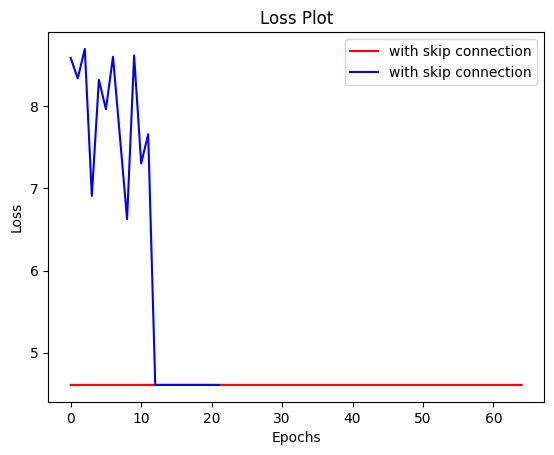

In [43]:
plt.plot(train_loss, color='r', label='with skip connection')
plt.plot(test_Loss, color='b', label='with skip connection')


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")

plt.legend()
plt.show()

The model should perform better with the residual networks, as we add the input again so that our model could remeber the initial inputs.Here the model has overfitted on the data that is why the training loss is decreasing but testing loss is not good. We have solve this by making the model less complex. I have reported the accuracy , precision, recall corresponding to each network.